In [1]:
%load_ext autoreload
%autoreload 2

import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.stats import norm
from scipy.spatial import distance

from utils.metrics import hilbert_metric, hilbert_metric_chained
from utils.plotting import hilbert_plot

from scenarios.congestion import prox_operator

print(os.getcwd())

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 100
plt.rcParams["savefig.dpi"] = 160
plt.rcParams['text.usetex'] = True


IMAGE_DIR = "images/"
os.makedirs(IMAGE_DIR, exist_ok=True)

/home/manifold/Documents/pyprojects/mva-optimaltransport/project


# Room setup

We define a domain $\Omega$ and obstacles $\mathscr{O}$.

$\newcommand{\NN}{\mathbb N}$
$\newcommand{\RR}{\mathbb R}$
$\newcommand{\dif}{\mathrm{d}}$
$\renewcommand{\epsilon}{\varepsilon}$
$\renewcommand{\phi}{\varphi}$
$\newcommand{\suchthat}{\mathrm{s.t.}}$
$$
\DeclareMathOperator{\supp}{supp}
\DeclareMathOperator*{\argmin}{argmin}
\DeclareMathOperator*{\argmax}{argmax}
$$
$\newcommand{\bfR}{\mathbf R}$
$\newcommand{\bfP}{\mathbf P}$
$\DeclareMathOperator{\divg}{div}$
$\DeclareMathOperator{\supp}{supp}$
$\DeclareMathOperator{\KL}{KL}$
$\DeclareMathOperator{\prox}{prox}$

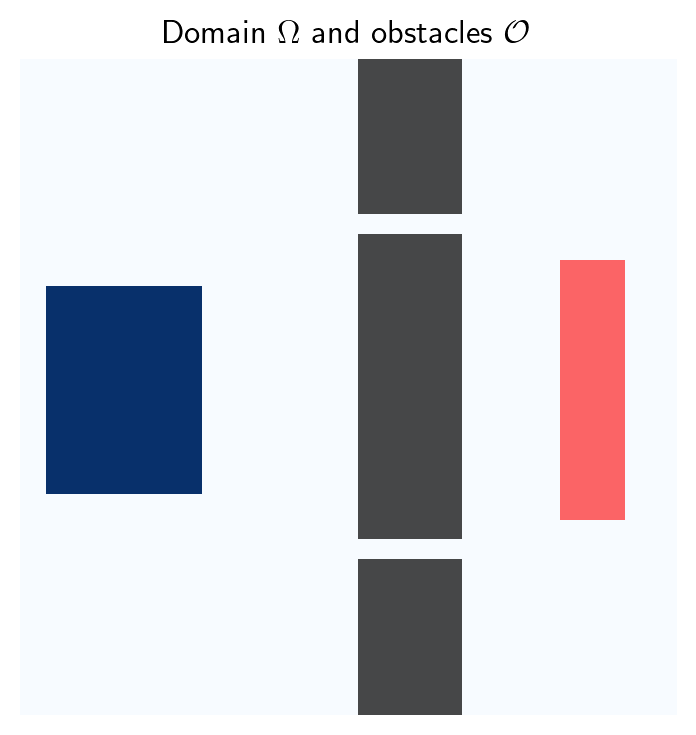

In [2]:
from utils import plot_domain, plot_measure
from utils.rooms import room1, setup1

nx = ny = 101
xar = np.linspace(0, 1, nx)
xg, yg = np.meshgrid(xar, xar)

extent = [0, xar.max(), 0, xar.max()]

# Obstacle domain
rho_0, mask, exit_mask = setup1(xg, yg)

obstacle_idx = np.argwhere(mask)

domain_img = np.zeros((nx, nx, 4))
domain_img[mask, 3] = 1.

# Exit (target)

exit_layer = np.zeros((ny, nx, 4))
exit_layer[exit_mask, 0] = 1.
exit_layer[exit_mask, 3] = 1.

fig = plt.figure(figsize=(4,4))
plot_domain(domain_img, extent=extent)
plot_measure(rho_0, extent=extent, cmap=cm.Blues)
plot_domain(exit_layer, alpha=.6)

plt.title("Domain $\\Omega$ and obstacles $\\mathcal{O}$")
plt.tight_layout()
plt.axis('off');

# Transport with potential target

$R = R_{0,1}$ is the marginal of the 2D Wiener measure at times $t=0,1$, which is given by the Gaussian kernel
$$
    R(x,y) = G_1(y_{0}-x_{0})G_1(y_{1}-x_{1})
$$
where $G_t \sim \mathcal N(0,t)$.

Convolution with respect to this kernel can be computed fast.

dt: 10.0


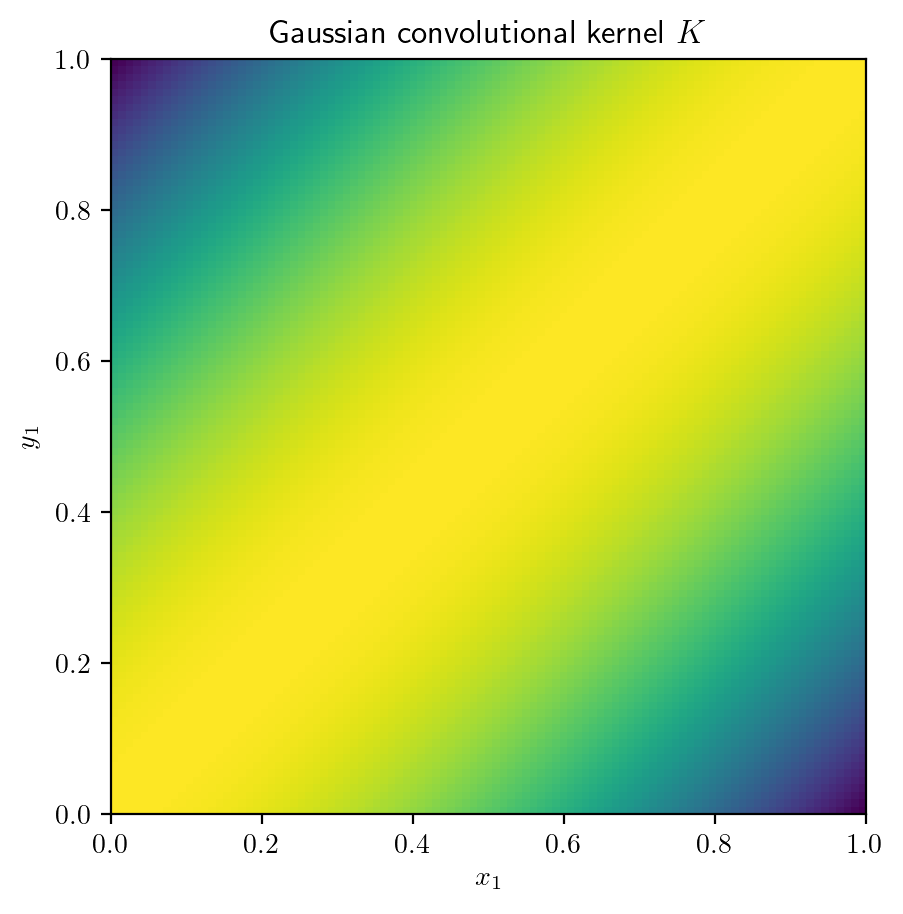

In [3]:
# x-direction kernel
cost_mat1 = distance.cdist(xar[:, None],
                           xar[:, None])  # distance between 1st-coordinates

TMAX = 10.  # maximum time

# Gaussian PDF applied element-wise

tmax = TMAX
dt = tmax / 1.
print("dt:", dt)
K1 = norm.pdf(cost_mat1, scale=dt ** .5)
K1.shape

# Convolutioned kernel
K_kernel = lambda x: np.dot(K1 @ x, K1)

plt.imshow(K1, origin='lower', interpolation='none',
           extent=extent)
plt.title("Gaussian convolutional kernel $K$")
plt.xlabel("$x_1$")
plt.ylabel("$y_1$");

We start to move towards a mean-field control problem.

Given a marginal $\rho_0$, we now solve
$$
    \inf_\gamma H(\gamma | R) + G(P^1_\#\gamma)
$$
subject to $P^0_\#\gamma = \rho_0$, and with the penalty functional
$$
    G(\mu) = \int_\Omega \Psi(x)\,\dif\mu(x)
$$

We can use the potential $\Psi$ to target a desired distribution, as a relaxation of the former hard-constraint problem.

## Defining a potential $\Psi$

We take
$$
    \Psi(x) = d(x, \mathscr{A})^2
$$
where $\mathscr{A}$ is a set.

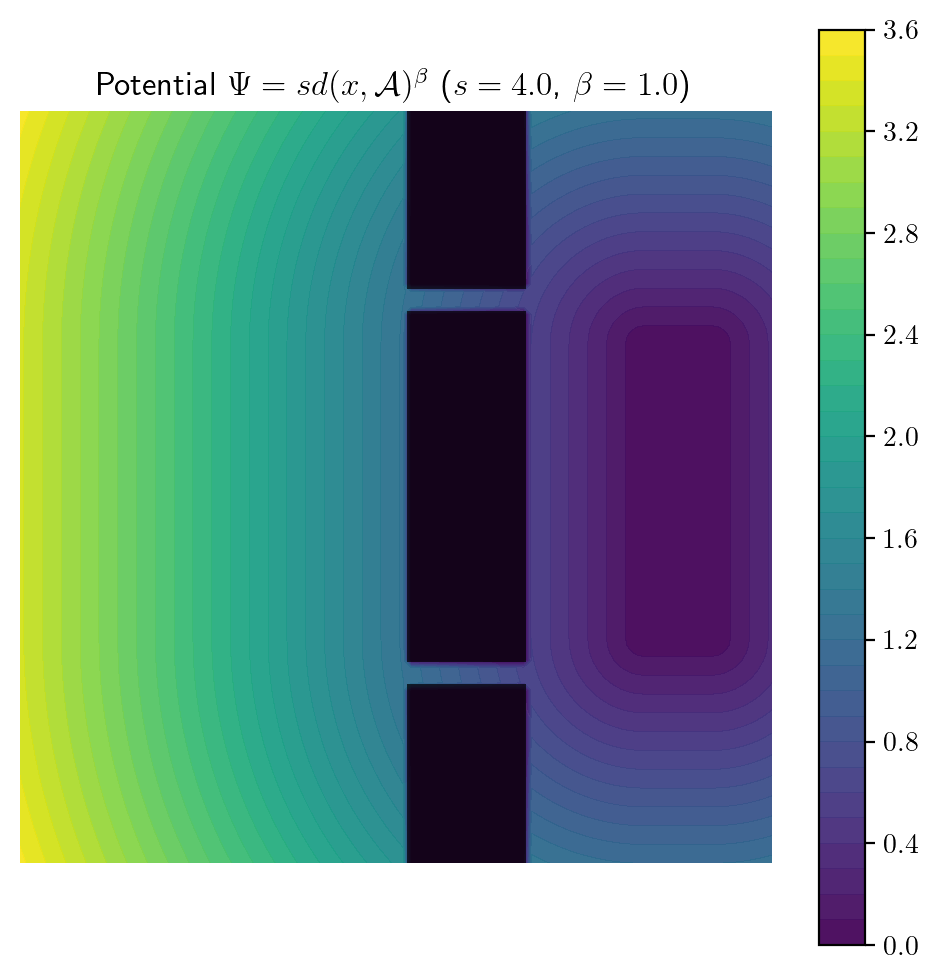

In [4]:
grid_arr_ = np.dstack([xg, yg])
grid_arr_flat = grid_arr_.reshape(nx*nx, 2)

target_points = grid_arr_flat[exit_mask.flatten()]

all_dists_ = distance.cdist(grid_arr_flat, target_points)

dist_to_target = all_dists_.min(axis=1)
dist_to_target = dist_to_target.reshape(nx, nx)

beta = 1
premul = 4
psi_potential_ = premul * dist_to_target ** beta

alphm = .95

fig = plt.figure()
ax = fig.add_subplot()
im_ = ax.contourf((1-mask)*psi_potential_,
                  extent=extent, alpha=alphm, levels=40)
#im_ = plot_measure((1-mask) * potential_new_, extent=extent, alpha=alphm, cmap=cm.viridis)
plot_domain(domain_img, extent=extent)
#plot_domain(exit_layer, alpha=.3)

ax.set_title("Potential $\\Psi = sd(x,\mathcal{A})^\\beta$ ($s=%.1f$, $\\beta=%.1f$)" 
             % (premul, beta))
#ax.set_aspect('auto')
fig.colorbar(im_)
plt.axis('off');
plt.tight_layout();

In [5]:
fig.savefig(IMAGE_DIR+"naive_potential.png", dpi='figure')

The discretized problem
$$
\begin{aligned}
    &\inf_\gamma H(\gamma|R) + \langle \Psi, \gamma^T\mathbf 1\rangle\\
    \text{s.t.}\ & \rho_0 = \gamma\mathbf 1
\end{aligned}
$$
can be shown to have a closed-form solution. Indeed, solving this convex problem leads to the following optimality condition:
$$
\begin{aligned}
    \gamma^* &= R \odot (e^{u_0^*} \otimes e^{-\Psi}) \\
    e^{u_0^*} &= \frac{\rho_0}{Re^{-\Psi}}
\end{aligned}
$$

Then, we get the final distribution $\rho_1$ as
$$
    \rho_1 = (\gamma^*)^T\mathbf 1
    = e^{-\Psi} \odot R e^{u_0^*}
$$

In [6]:
u0 = rho_0 / K_kernel(np.exp(-psi_potential_))
rho_final = np.exp(-psi_potential_) * K_kernel(u0)

print("Total mass:", rho_final.sum())

# Check the Lagrange multiplier condition:
print("Mass is zero on mask:", np.allclose(rho_final * mask, 0))

print("Amount on mass on mask:", np.sum(rho_final * mask))

Total mass: 1.0
Mass is zero on mask: False
Amount on mass on mask: 0.1602307692911954


So we see the total mass is still $1$, but that there is mass contained on the obstacles (which was previsible, we did nothing to prevent that).

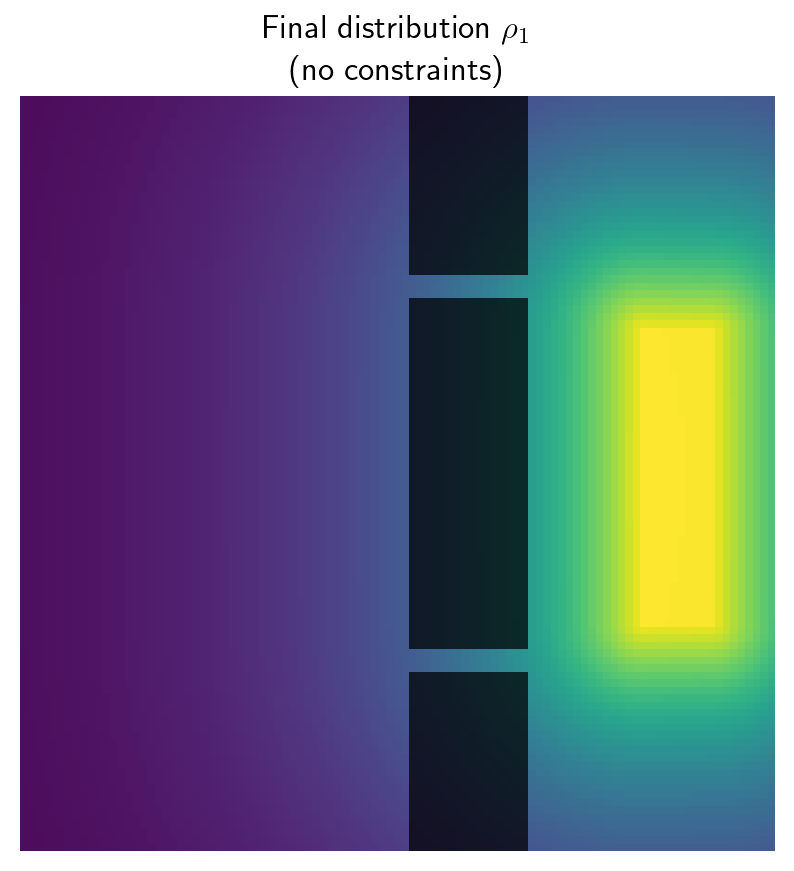

In [7]:
#fig = plt.figure(figsize=(9, 8), dpi=90)
fig = plt.figure()

alphm = 0.95
plot_measure(rho_final, alpha=alphm, cmap=cm.viridis)
plot_domain(domain_img)
plt.title("Final distribution $\\rho_1$\n(no constraints)")
plt.axis('off');

fig.savefig(IMAGE_DIR+"fuzzy_transport_noobstacle.png", bbox_inches='tight')

## Adding obstacles and congestion constraint

We can decompose the final distribution criterion $G$ as the sum of the potential $\Psi$ and a hard constraint:
$$
    G(\mu) = \imath_{0}(\mathbf{1}_{\mathscr O}\mu) + \imath_{[0,\bar m]}(\mu) + \langle \Psi, \mu\rangle.
$$

The discretized problem is then
$$
\begin{aligned}
    &\inf_{\gamma,\rho_1} H(\gamma|R) + \langle \Psi, \rho_1 \rangle \\
    \text{s.t.}\ & \gamma \mathbf{1} = \rho_0  \\
    & \gamma^T\mathbf 1 = \rho_1   \\
    & \rho_1 \leq \bar m \\
    & \rho_1(x) = 0 \quad \forall x \in \mathscr O 
\end{aligned}
$$

The terminal distribution is given as a function of the Lagrange multipliers $u_0, u_1$ by
$$
    \rho_1 = \gamma^T\mathbf 1 = a_1^* \odot R a_0^*
$$
where $a_0^* = \rho_0 / Ra_1^*$, $a^*_1 = e^{u_1^*} = \min\left(\frac{\bar m}{Ra_0^*}, e^{-\Psi/\epsilon}\right)$.

In [8]:
# maximal congestion using previous final distrib
kappa = 1.
congest_max = kappa * rho_0.max()

## RECALL: mask is the indicatrix of obstacles

hmet = []  # Hilbert metric

thresh_ = 1e-10

u1 = np.ones_like(rho_0)
n_iter = 400

for _ in range(n_iter):
    u0_old = u0
    u1_old = u1
    
    conv = K_kernel(u1)
    u0 = rho_0 / conv  # potential u0
    conv = K_kernel(u0)
    u1 = prox_operator(conv, mask, congest_max, psi_potential_)/conv
    
    hmet.append(hilbert_metric_chained([u0,u1], [u0_old, u1_old]))
    
    if hmet[-1] < thresh_:
        print("Hilbert metric low, stopping.")
        break
    
rho_final = K_kernel(u0) * u1

print("Total mass:", rho_final.sum())
# Check the Lagrange multiplier condition:
print("Mass is zero on mask:", np.allclose(rho_final * mask, 0))

Hilbert metric low, stopping.
Total mass: 1.0
Mass is zero on mask: True


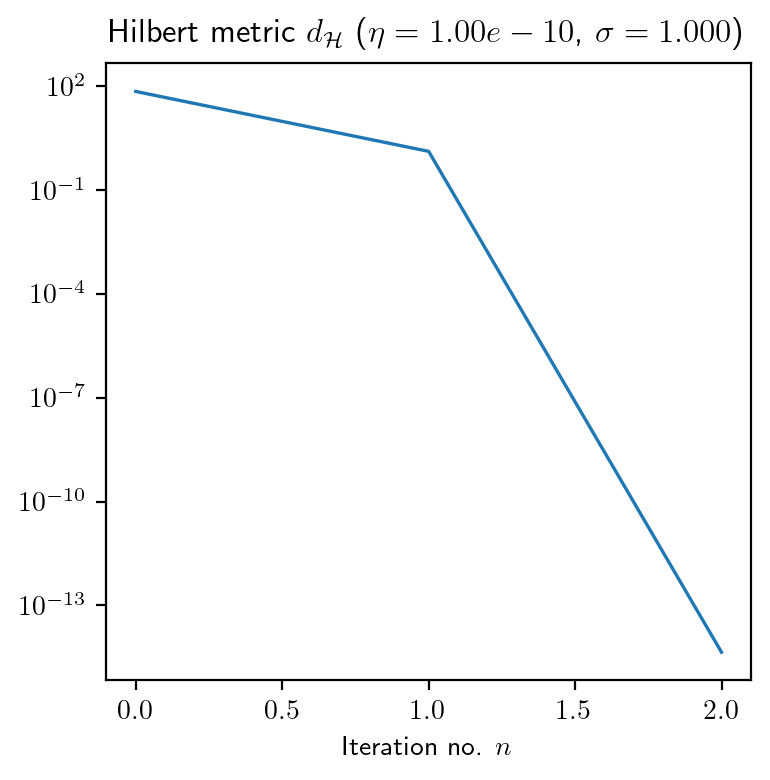

In [9]:
fig = hilbert_plot(hmet, thresh_, 1.)

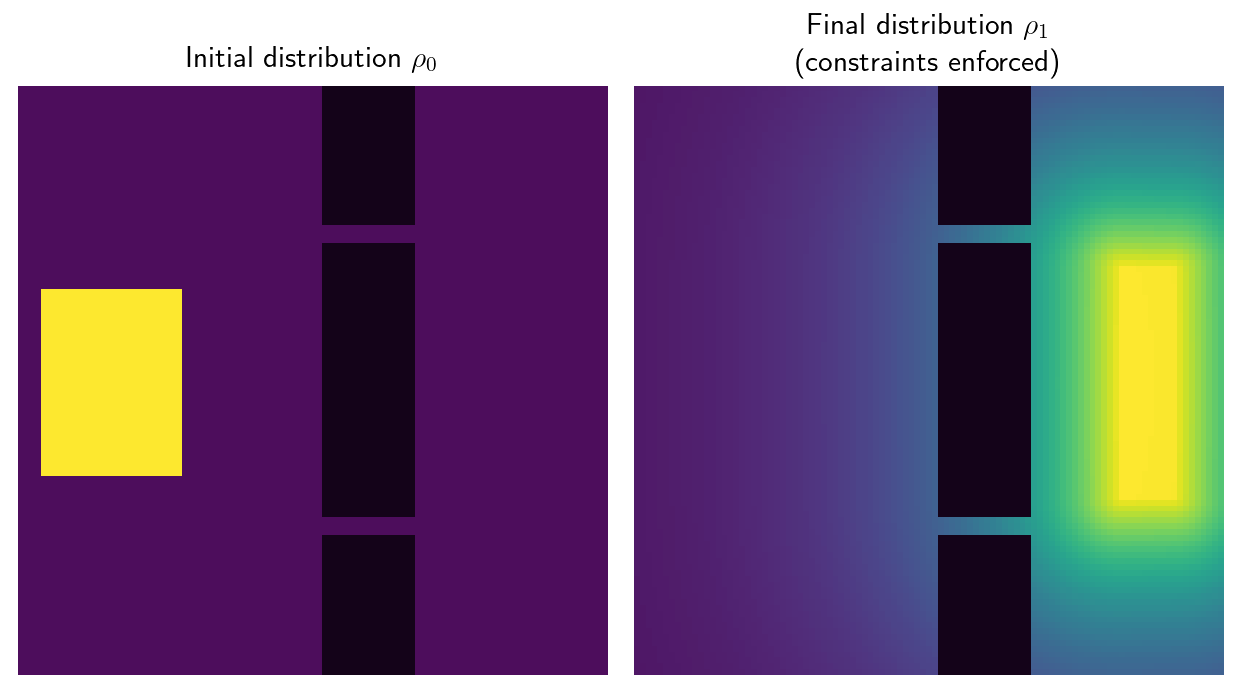

In [10]:
fig = plt.figure(figsize=(7, 6), dpi=90)

alphm = 0.95

plt.subplot(121)
plot_measure(rho_0, alpha=alphm, cmap=cm.viridis)
plot_domain(domain_img)
plt.title("Initial distribution $\\rho_0$")
plt.axis('off')

plt.subplot(122)
plot_measure(rho_final, alpha=alphm, cmap=cm.viridis)
plot_domain(domain_img)
plt.title("Final distribution $\\rho_1$\n(constraints enforced)")
plt.axis('off');

fig.tight_layout();

In [11]:
fig.savefig(IMAGE_DIR+"fuzzy_transport_withobstacle.png", bbox_inches='tight')

## Viscosity parameter

We now want to approximate the MFG problem
$$
\begin{align}
    -\partial_tu -\frac{\sigma^2}{2}\Delta u + \frac12|\nabla u|^2 &= f[\rho_t] \\
    \partial_t\rho - \frac{\sigma^2}{2}\Delta\rho - \divg(\rho\nabla u) &= 0\\
    \rho_0 \text{ given}& \\
    u(T, \cdot) = g[\rho_T]&
\end{align}
$$

We set $\epsilon = \sigma^2$. The MFG-OT problem is then given as
$$
\begin{aligned}
    &\inf_{\gamma,\rho_1} \epsilon H(\gamma | R_\epsilon) + G(\rho_1) \\
    \suchthat \ & P^1_\#\gamma = \rho_1
\end{aligned}
$$

tmax: 10.0
dt: 10.0
Epsilon: 0.010000000000000002


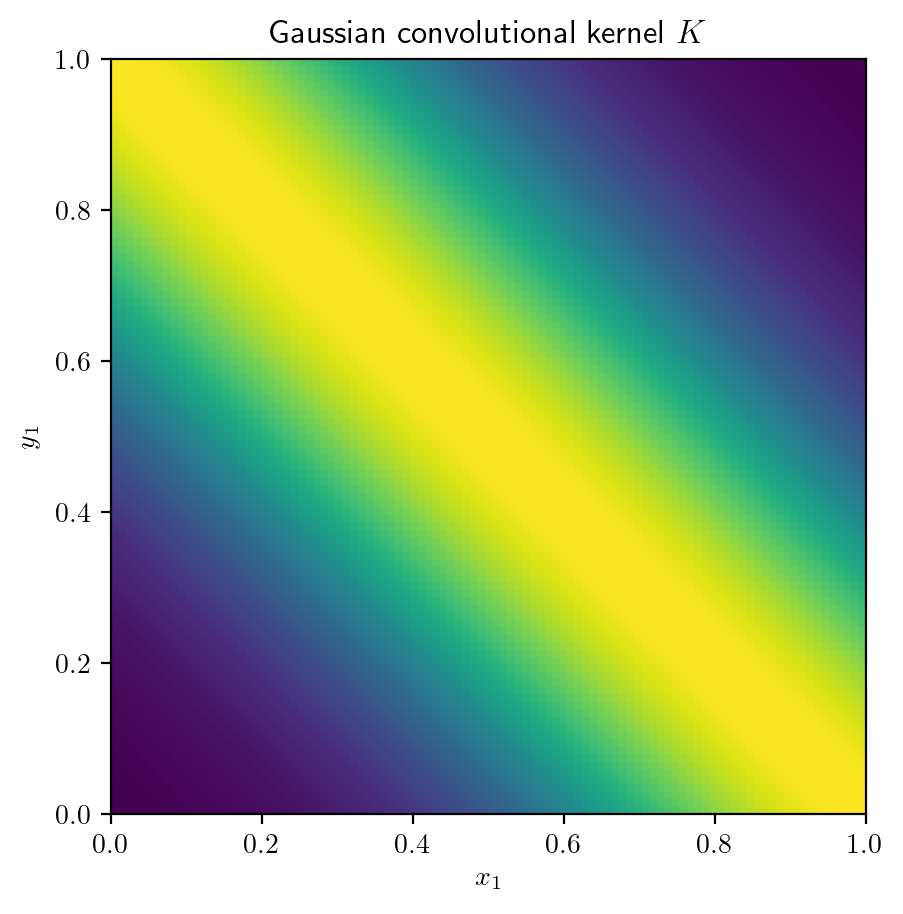

In [12]:
sigma = .1
epsilon = sigma ** 2
## New epsilon-kernel

tmax = TMAX
dt = tmax / 1.
print("tmax:", tmax)
print("dt:", dt)
print("Epsilon:", epsilon)

K1_eps = norm.pdf(cost_mat1, scale=sigma * dt ** .5)

from contraction import FactoredKernel
K_eps_op = FactoredKernel(K1_eps, K1_eps)

plt.imshow(K1_eps, interpolation='none',
           extent=[0, xar.max(), 0, xar.max()])
plt.title("Gaussian convolutional kernel $K$")
plt.xlabel("$x_1$")
plt.ylabel("$y_1$");

In [13]:
# maximal congestion using previous final distrib
kappa = 1.
congest_max = kappa * rho_0.max()

hmet = []
thresh_ = 1e-10

n_iter = 400
tau = 1e-20

u1 = np.ones_like(rho_0)

for n in range(n_iter):
    u0_old = u0
    u1_old = u1
    
    u0 = rho_0 / (K_eps_op(u1)+tau)  # potential u0
    conv0 = K_eps_op(u0) + tau
    u1 = prox_operator(conv0, mask, congest_max, psi_potential_,epsilon)/conv0
    
    hmet.append(hilbert_metric_chained([u0,u1], [u0_old, u1_old]))
    print("iteration #%d: %.2e"% (n, hmet[-1]), end="\r")
    
    if hmet[-1] < thresh_:
        print("Early stopping")
        break

rho_final = K_eps_op(u0) * u1

print("Total final mass:", rho_final.sum())

print("Mass on mask:", rho_final[mask].sum())

Total final mass: 0.9999999973408755
Mass on mask: 0.0


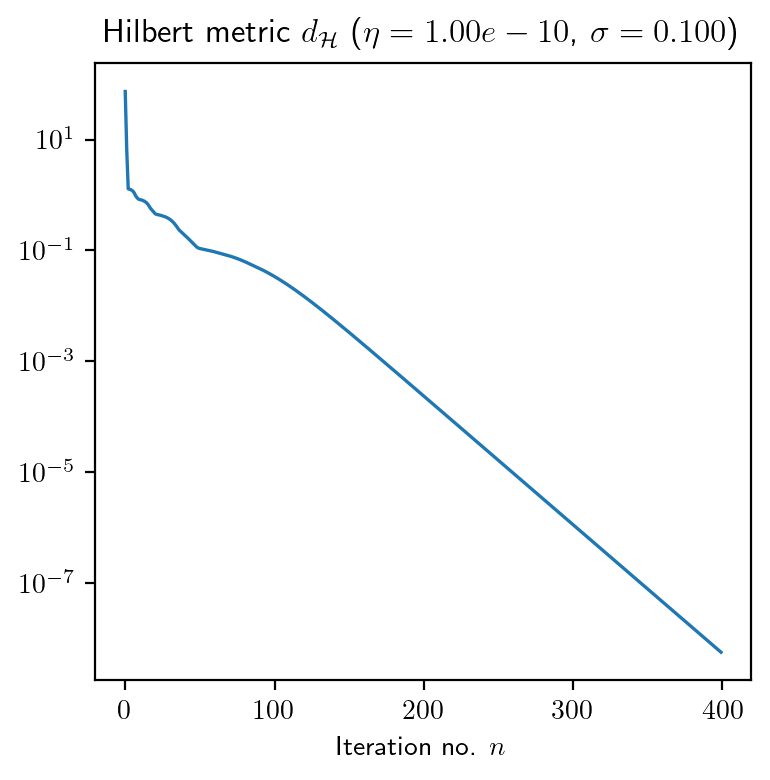

In [14]:
from utils.plotting import hilbert_plot

fig = hilbert_plot(hmet, thresh_, sigma)

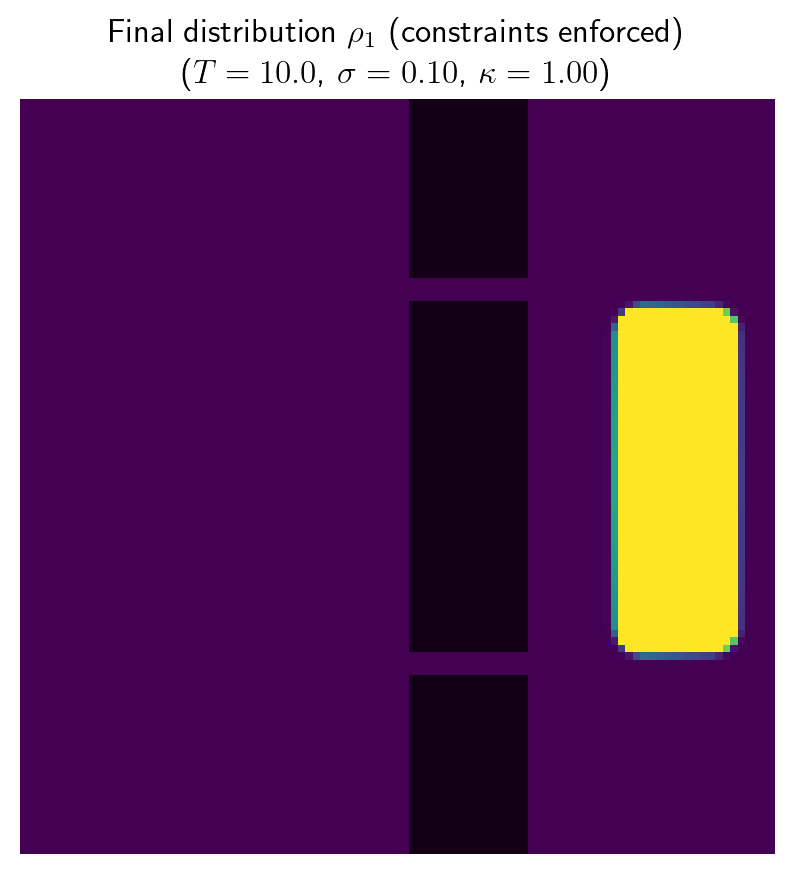

In [15]:
#fig = plt.figure(figsize=(9, 8), dpi=90)
fig = plt.figure()
"""plt.subplot(121)
plot_measure(rho_0)
plot_domain(domain_img)
plt.axis('off')
plt.title("Initial distribution $\\rho_0$")

plt.subplot(122)
"""
plot_measure(rho_final, cmap=cm.viridis)
plot_domain(domain_img)
plt.title("Final distribution $\\rho_1$ (constraints enforced)"+
          "\n($T=%.1f$, $\sigma=%.2f$, $\kappa=%.2f$)"
          % (tmax, sigma, kappa))
plt.axis('off');

In [16]:
fig.savefig(IMAGE_DIR+"fuzzy_transport_lowvisc.png", bbox_inches='tight')

## "Smarter" potential function

We see from the previous examples that the 

We will use a new potential function $\Psi$ obtained by solving the Eikonal equation with a given target set $\Gamma$
$$
\begin{aligned}
    &\|\nabla\Psi(x)\|^2 = 1/f(x) \\
    &\Psi(x) = 0\ \text{ on }\Gamma
\end{aligned}
$$

We coded an efficient Fast Sweeping Method (FSM) (see [Zhao](#biblio)) in Cython to recover the appropriate distance for our domain topology.

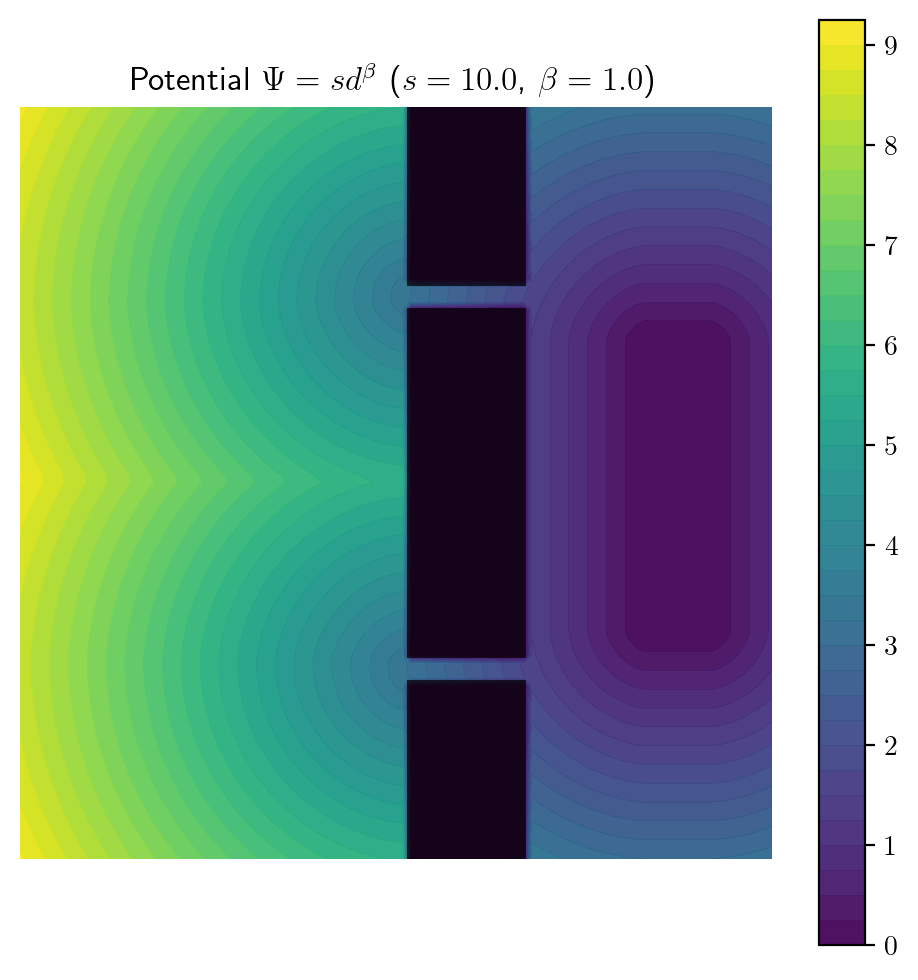

In [36]:
from utils import fast_sweep

# Initialize the new distance array
speed_field = np.ones((nx, nx))
speed_field[mask] = 1e3  # "Kill" walking through the obstacles
dx = xar[1] - xar[0]
sweep_iters = 150

potential_new_ = fast_sweep(speed_field, dx, exit_mask, sweep_iters, init_value=10.)
beta = 1.
premul = 10
potential_new_ = premul * potential_new_ ** beta

fig = plt.figure()
ax = fig.add_subplot()
im_ = ax.contourf((1-mask)*potential_new_,
                  extent=extent, alpha=alphm, levels=40)
#im_ = plot_measure((1-mask) * potential_new_, extent=extent, alpha=alphm, cmap=cm.viridis)
plot_domain(domain_img, extent=extent)
#plot_domain(exit_layer, alpha=.3)

ax.set_title("Potential $\\Psi = sd^\\beta$ ($s=%.1f$, $\\beta=%.1f$)" 
             % (premul, beta))
#ax.set_aspect('auto')
fig.colorbar(im_)
plt.axis('off');
plt.tight_layout();

In [37]:
# maximal congestion using previous final distrib
kappa = 1.
congest_max = kappa * rho_0.max()

thresh_ = 1e-9
hmet = []

n_iter = 1200
u1 = np.ones_like(rho_0)

for n in range(n_iter):
    u0_old = u0
    u1_old = u1
    
    u0 = rho_0 / K_eps_op(u1)  # potential u0
    conv0 = K_eps_op(u0)
    u1 = prox_operator(conv0, mask, congest_max, potential_new_, epsilon)/conv0
    
    hmet.append(hilbert_metric_chained([u0,u1], [u0_old, u1_old]))
    print("iteration #%d: %.2e"% (n, hmet[-1]), end="\r")
    
    if hmet[-1] < thresh_:
        print("\nEarly stopping at %d" % n)
        break
rho_final = K_eps_op(u0) * u1

print("Total final mass:", rho_final.sum())
print("Maximal density:", rho_final.max())

iteration #360: 9.79e-10
Early stopping at 360
Total final mass: 0.9999999995383785
Maximal density: 0.0013020833333333335


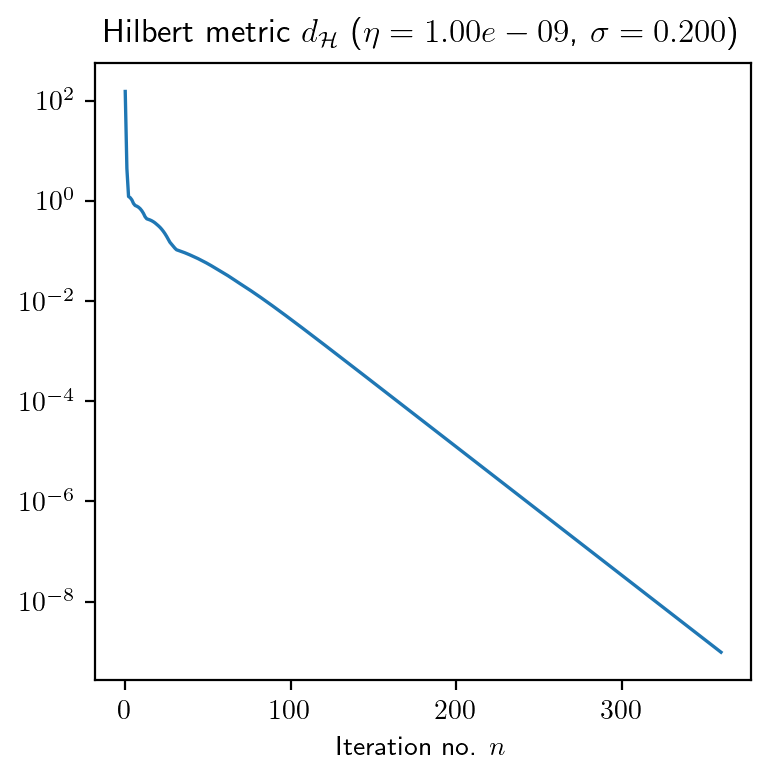

In [38]:
fig = hilbert_plot(hmet, thresh_, sigma)

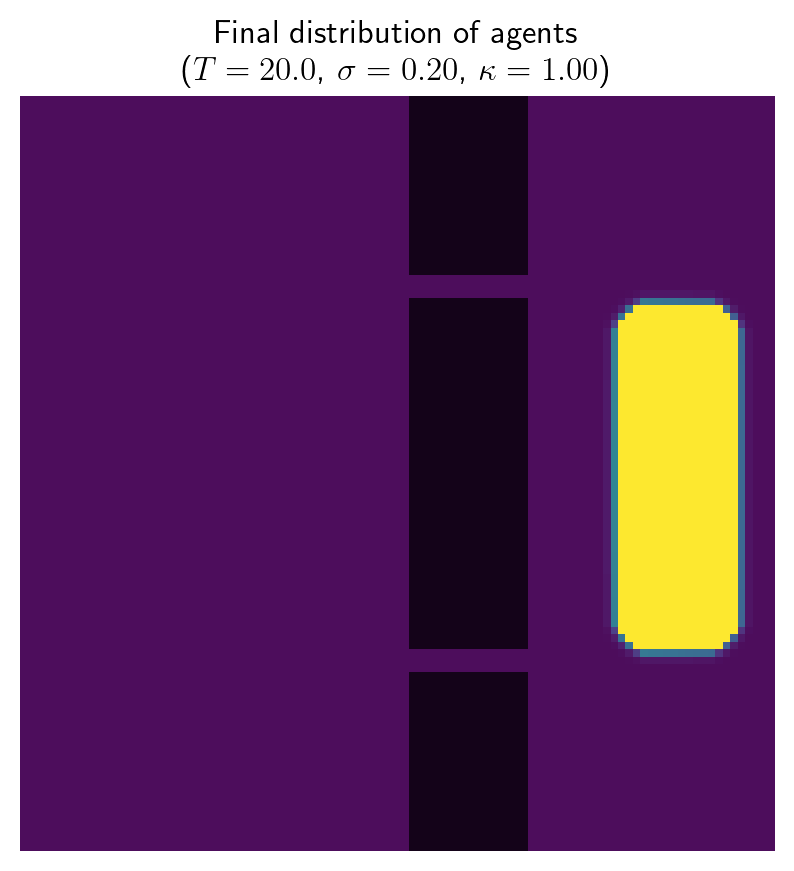

In [39]:
#fig = plt.figure(figsize=(9, 8), dpi=90)
fig = plt.figure()
alphm = .95

im_ = plot_measure(rho_final, alpha=alphm)
plot_domain(domain_img)
plt.title("Final distribution of agents\n($T=%.1f$, $\\sigma=%.2f$, $\kappa=%.2f$)"
          % (tmax,sigma,kappa))
plt.axis('off');

In [40]:
fig.savefig(IMAGE_DIR+"eikonal_transport_lowvisc.png",
            bbox_inches='tight')

# Three time steps

We formulate the problem as
$$
\begin{aligned}
    &\inf_{\gamma} \epsilon H(\gamma|R) + hF(P^1_\#\gamma) + G(P^2_\#\gamma) \\
    \mathrm{s.t.}\ & P^0_\#\gamma = \rho_0
\end{aligned}
$$

The final penalty $G$ is given by the obstacle constraint, hard congestion and the potential $\Psi$:
$$
    G(\mu) = \langle \Psi, \mu\rangle +
    \imath_{\{\mu \leq \bar{m}\}} + \imath_0(\mathbf 1_{\mathscr O}\mu)
$$

We set $F$ to be both the hard congestion and obstacle constraint
$$
    F(\mu) = \imath_{\{\mu \leq \bar{m}\}} + \imath_0(\mathbf 1_{\mathscr O}\mu)
$$

In that case, the KL-proximal operator for $F$ is given by
$$
    \prox^{\KL}_F(\beta) = \min(\beta,
    \bar m \mathbf{1}_{\Omega\backslash\mathscr O})
$$

tmax: 20
dt: 10.0
Epsilon: 0.0016


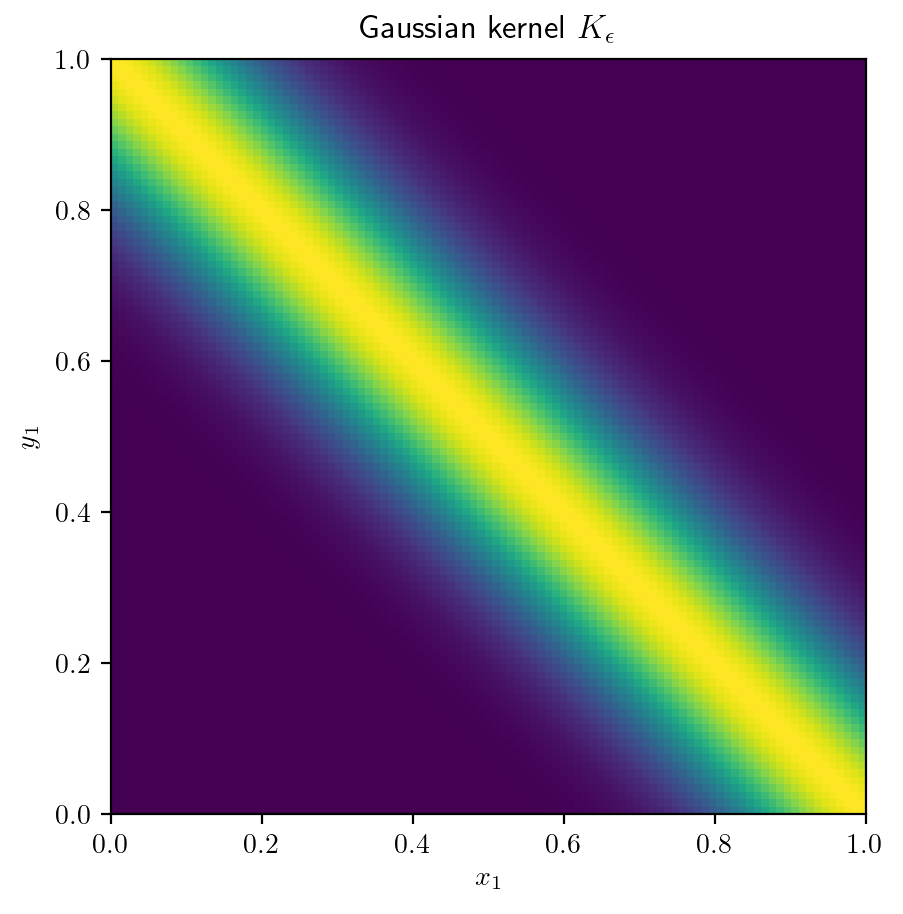

In [62]:
sigma = 0.04
epsilon = sigma ** 2

tmax = 20
dt = tmax / 2.

print("tmax:", tmax)
print("dt:", dt)
print("Epsilon:", epsilon)
## New epsilon-kernel
K1_eps = norm.pdf(cost_mat1, scale=sigma * dt ** .5)

from contraction import FactoredKernel

K_eps_op = FactoredKernel(K1_eps, K1_eps)

plt.imshow(K1_eps, interpolation='none', extent=[0,xar.max(),0,xar.max()])
plt.title("Gaussian kernel $K_\\epsilon$")
plt.xlabel("$x_1$")
plt.ylabel("$y_1$");

In [63]:
# maximal congestion using previous final distrib
kappa = 1.
congest_max = kappa * rho_0.max()

from scenarios.congestion import multi_sinkhorn
from contraction import compute_marginals

a_s = [
    np.ones((nx, nx)) for _ in range(3)
]

import copy
import time
t_a = time.time()
num_iters = 300
hmet = []

thresh_ = 1e-12

for n in range(num_iters):
    a_olds = copy.deepcopy(a_s)
    multi_sinkhorn(a_s, K_eps_op, rho_0, mask, congest_max, potential_new_)
    hmet.append(hilbert_metric_chained(a_s, a_olds))
    print("iteration #%d: %.2e"% (n, hmet[-1]), end="\r")
    if hmet[-1] <= thresh_:
        # Early stopping
        print()
        print("Hilbert metric below threshold -- stopping.")
        break
    
print("Elapsed time:", time.time() - t_a)

marginals = compute_marginals(a_s, K_eps_op)

iteration #2: 2.93e-14
Hilbert metric below threshold -- stopping.
Elapsed time: 0.023714303970336914


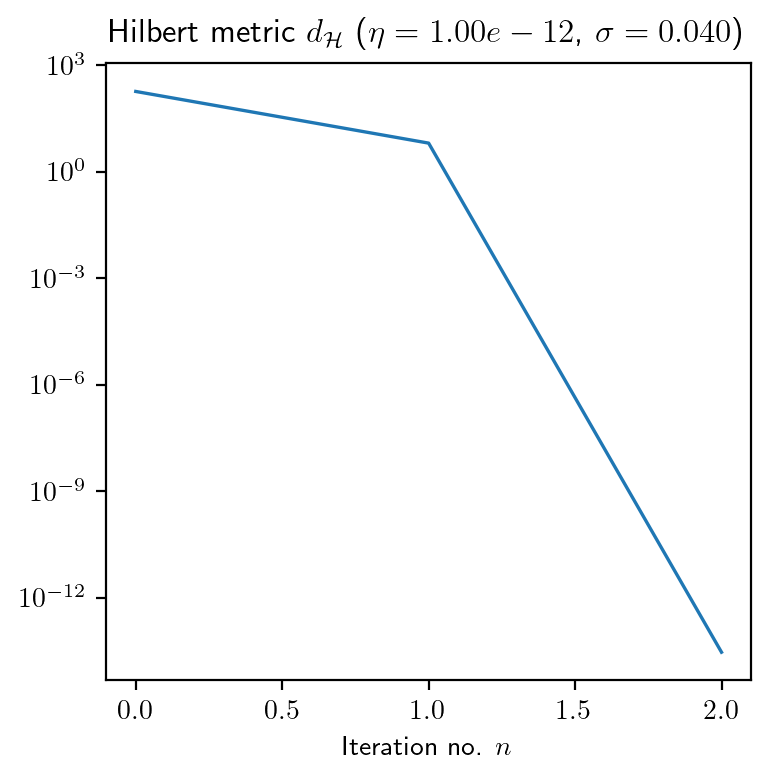

In [64]:
fig = hilbert_plot(hmet, thresh_, sigma)

In [65]:
for mu in marginals:
    print(mu.sum())

print("Linf error:", np.linalg.norm(
    marginals[0]-rho_0, ord=np.inf) / np.linalg.norm(rho_0, ord=np.inf))

1.0
1.0
1.0
Linf error: 4.85722573273506e-17


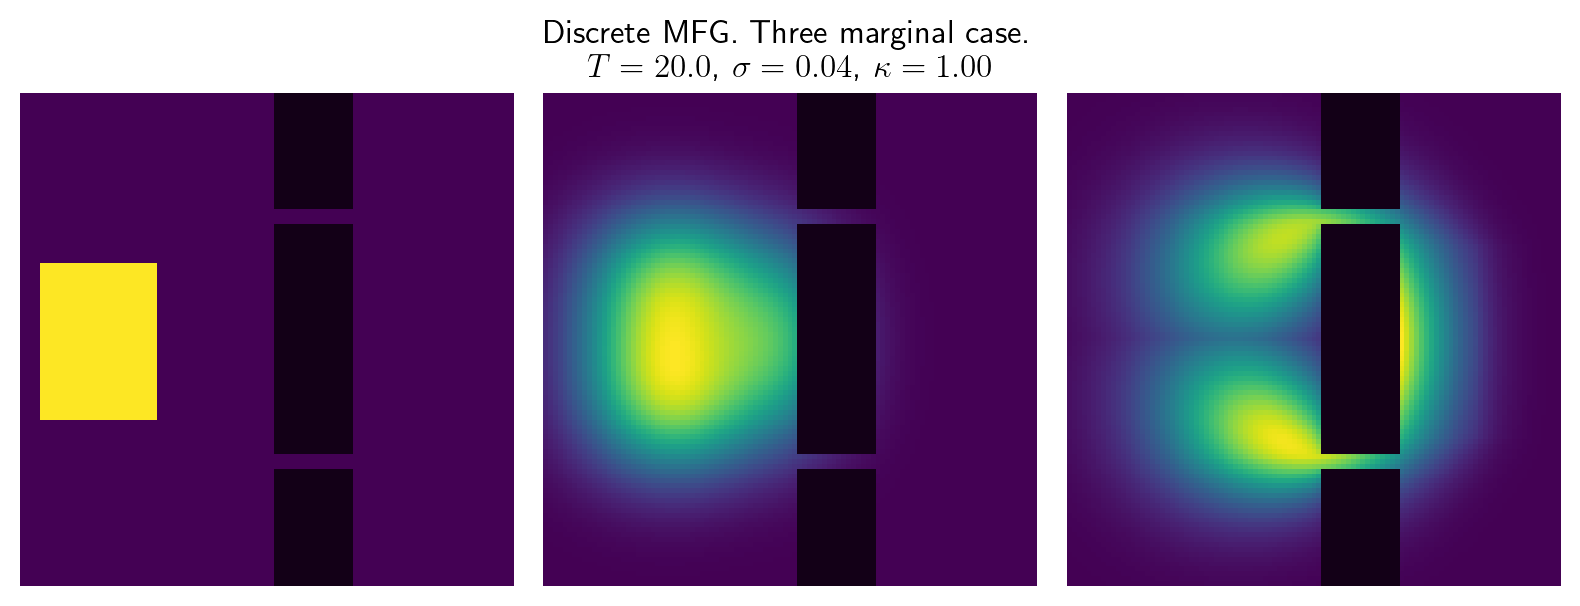

In [66]:
fig = plt.figure(figsize=(8, 4))

plt.subplot(131)
plot_measure(marginals[0], extent=extent)
plot_domain(domain_img, extent=extent)
plt.axis('off')

plt.subplot(132)
plot_measure(marginals[1], extent=extent)
plot_domain(domain_img, extent=extent)
plt.axis('off')

plt.subplot(133)
plot_measure(marginals[2], extent=extent)
plot_domain(domain_img, extent=extent)
plt.axis('off')
plt.tight_layout();
plt.suptitle(("Discrete MFG. Three marginal case.\n$T=%.1f$,"+
              " $\\sigma=%.2f$, $\kappa=%.2f$")
             % (tmax, sigma, kappa), y=.9);

In [67]:
fig.savefig(IMAGE_DIR+f"three_marginal_room1.png", bbox_inches='tight')

# Bibliography
<html><a name="biblio"></a></html>

1. [Zhao] Zhao, Hongkai. “A fast sweeping method for Eikonal equations.” Math. Comput. 74 (2004): 603-627.